In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('/home/cizinsky/garment-texture-completion')
CKPT_ROOT = '/scratch/izar/cizinsky/garment-completion/checkpoints'

from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
import pytorch_lightning as pl

import torch
from torchvision.transforms.functional import pil_to_tensor
from torchvision.utils import make_grid

from helpers.pl_module import GarmentInpainterModule
from helpers.dataset import get_dataloaders
from helpers.data_utils import denormalise_image_torch
from helpers.data_utils import torch_image_to_pil, denormalise_image_torch
from helpers.metrics import compute_all_metrics

from tqdm import tqdm

import pandas as pd

In [3]:
pl.seed_everything(42);

Seed set to 42


Checking when I last created the dataset:

In [11]:
!stat /scratch/izar/cizinsky/garment-completion/pbr_maps/dresscode/Batiste_Beige_Argyle/texture_diffuse.png

  File: /scratch/izar/cizinsky/garment-completion/pbr_maps/dresscode/Batiste_Beige_Argyle/texture_diffuse.png
  Size: 748130    	Blocks: 1472       IO Block: 4194304 regular file
Device: 31h/49d	Inode: 60784366    Links: 1
Access: (0644/-rw-r--r--)  Uid: (278297/cizinsky)   Gid: (30207/sc-ma4-unit)
Access: 2025-05-17 05:22:28.008988194 +0200
Modify: 2025-05-06 23:44:34.955320223 +0200
Change: 2025-05-06 23:44:34.955320223 +0200
 Birth: -


### Inspection of trained models

---


In [4]:
!ls /scratch/izar/cizinsky/garment-completion/checkpoints/

bright-universe-112  fast-universe-159	    rose-sun-129
cerulean-smoke-152   fearless-jazz-157	    sandy-capybara-119
cerulean-star-109    fluent-aardvark-116    soft-dust-146
cosmic-cosmos-123    glamorous-thunder-121  stellar-feather-136
crisp-cosmos-153     glorious-oath-130	    stellar-pond-132
curious-oath-144     glowing-disco-164	    swift-lake-110
devout-wind-122      graceful-cloud-156     twilight-sponge-160
eager-energy-111     grateful-terrain-163   unique-water-133
exalted-forest-117   honest-bird-113	    valiant-resonance-120
faithful-dew-158     lilac-hill-102	    vivid-smoke-128
fallen-dew-140	     morning-microwave-118  worthy-paper-139
fallen-shape-155     peach-firebrand-106


In [5]:
run_name = "fast-universe-159"
checkpoint_path = f"{CKPT_ROOT}/{run_name}/last.ckpt"
os.path.exists(checkpoint_path)

True

In [6]:
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
cfg = checkpoint["hyper_parameters"]
cfg.data.num_workers = 10
cfg.data.batch_size = 2
trn_dataloader, val_dataloader = get_dataloaders(cfg)

In [7]:
model = GarmentInpainterModule(cfg, trn_dataloader)
model.setup()
model.load_state_dict(checkpoint["state_dict"])
model.eval().cuda()
print("✅ Model loaded!")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Model loaded!


In [8]:
max_n_batches = 5
val_batches = [next(iter(val_dataloader)) for _ in range(max_n_batches)]

### Explore role of inference hyperparameters

In [ ]:
batch = val_batches[0]

In [ ]:
partial_img = batch["partial_diffuse_img"][2].unsqueeze(0).to("cuda")
image_guidance_scale = [2.5, 5.0, 7.5, 10.0]
text_guidance_scale = [2.5, 5.0, 7.5, 10.0]
results = []
for img_scale in image_guidance_scale:
    row_results = []
    for t_scale in text_guidance_scale:
        reconstructed_imgs = model.inference(partial_img, num_inference_steps=50, guidance_scale=t_scale, image_guidance_scale=img_scale)
        row_results.extend(reconstructed_imgs)
    results.append(row_results)


In [ ]:
fig, axs = plt.subplots(
    len(image_guidance_scale),
    len(text_guidance_scale),
    figsize=(5, 5),
    tight_layout=True
)

for i, img_scale in enumerate(image_guidance_scale):
    for j, t_scale in enumerate(text_guidance_scale):
        ax = axs[i, j]
        ax.imshow(results[i][j])
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor('white')

        # keep your per-row / per-col numeric labels if you want
        if j == 0:
            ax.set_ylabel(f"{img_scale}", rotation=0, labelpad=10, va='center')
        if i == 0:
            ax.set_title(f"{t_scale}")

# now add the “global” labels
fig.supxlabel("Text guidance scale", fontsize=12)
fig.supylabel("Image guidance scale", fontsize=12)

plt.show()

### Play around with inference hyperparameters

In [ ]:
batch = val_batches[0]

In [ ]:
reconstructed_imgs = model.inference(batch["partial_diffuse_img"][:n].to("cuda"), num_inference_steps=50, guidance_scale=7.5, image_guidance_scale=1.5)

In [20]:
cond_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["partial_diffuse_img"][:n])]
target_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["full_diffuse_img"][:n])]

In [ ]:
def plot_images(index):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(cond_images[2])
    axs[0].set_title("Condition")
    axs[0].axis("off")
    axs[1].imshow(results[index])
    img_guidance = image_guidance_scale[index]
    axs[1].set_title(f"Predicted, IMG_GUIDE={img_guidance}")
    axs[1].axis("off")
    axs[2].imshow(target_images[2])
    axs[2].set_title("Target")
    axs[2].axis("off")
    plt.show()

interact(plot_images, index=IntSlider(min=0, max=len(results)-1, step=1));

### Inspect results of the ablation on image vs text guidance

In [23]:
import wandb
import json

import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
tmp_dir = "/scratch/izar/cizinsky/garment-completion/tmp"

In [15]:
run = wandb.init()
artifact = run.use_artifact('ludekcizinsky/pbr-generation/run-w5daifhx-best_inference_setup:v0', type='run_table')
artifact.download(tmp_dir)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ludekcizinsky to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


'/scratch/izar/cizinsky/garment-completion/tmp'

In [16]:
!ls {tmp_dir}

best_inference_setup.table.json


In [21]:
with open(f'{tmp_dir}/best_inference_setup.table.json', 'r') as f:
    table_json = json.load(f)

df = pd.DataFrame(
    table_json['data'],
    columns=table_json['columns']
)

print(f"df.shape: {df.shape}")
df.head()

df.shape: (2500, 6)


,sample_idx,img_scale,text_scale,ssim,psnr,lpips
0,0,1.5,1.5,0.077438,14.522379,0.636522
1,1,1.5,1.5,0.118236,20.316708,0.712009
2,2,1.5,1.5,0.005973,12.173512,0.627456
3,3,1.5,1.5,0.047689,8.358482,0.749382
4,4,1.5,1.5,0.059711,11.917653,0.594570


,text_scale,img_scale,mean_ssim,mean_psnr,mean_lpips
0,1.5,1.5,0.075696,11.066522,0.661568
1,1.5,2.5,0.082375,10.985801,0.644519
2,1.5,5.0,0.092161,10.216820,0.670103
3,1.5,7.5,0.092034,10.048200,0.681120
4,1.5,10.0,0.092771,9.810061,0.684917


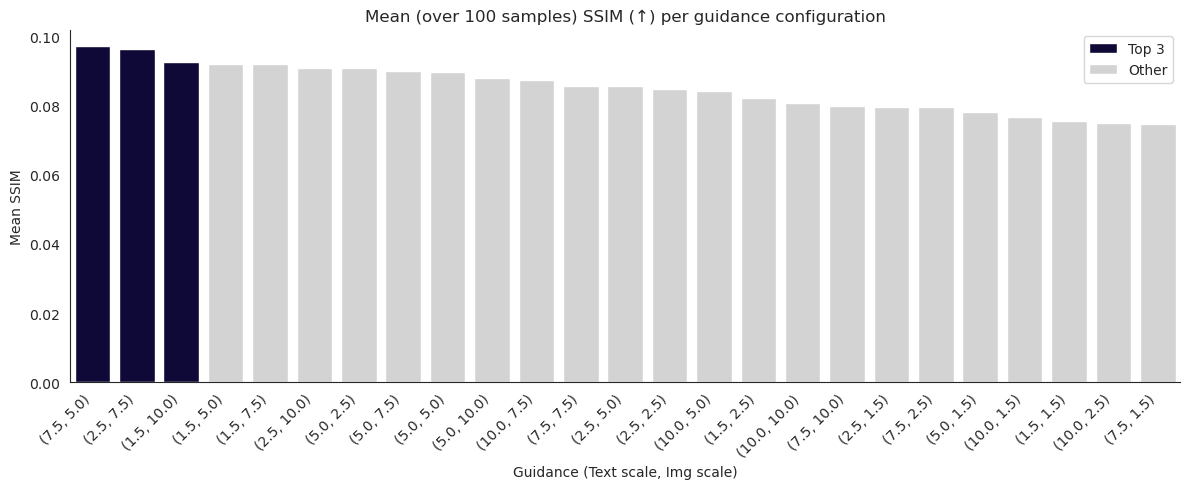

In [41]:
grouped = (
    df
    .groupby(['text_scale','img_scale'])
    .agg(mean_ssim = ('ssim','mean'),
         mean_psnr = ('psnr','mean'),
         mean_lpips= ('lpips','mean'))
    .reset_index()
)

# ─── 3. MAKE A COMBO LABEL ──────────────────────────────────────────────────────
grouped['combo'] = grouped.apply(
    lambda r: f"({r.text_scale}, {r.img_scale})", axis=1
)

# ─── 4. FLAG TOP-3 ──────────────────────────────────────────────────────────────
# sort descending and mark top3
grouped = grouped.sort_values(f'mean_ssim', ascending=False).reset_index(drop=True)
grouped['highlight'] = ['Top 3' if i < 3 else 'Other' for i in grouped.index]

# ─── 5. PLOT ───────────────────────────────────────────────────────────────────
sns.set_style("white")  # clean background

plt.figure(figsize=(12,5))
bar = sns.barplot(
    data=grouped,
    x='combo', y='mean_ssim',
    hue='highlight', dodge=False,
    palette={'Top 3': "#08023d", 'Other': 'lightgrey'}  # seaborn defaults for Top 3, grey for others
)
ax = bar
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped['combo'], rotation=45, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
bar.set_xlabel('Guidance (Text scale, Img scale)')
bar.set_ylabel('Mean SSIM')
bar.set_title('Mean (over 100 samples) SSIM (↑) per guidance configuration')

# remove the legend title and frame
bar.legend_.set_title(None)
plt.tight_layout()
plt.show()